## Imbalanced Data Sampler

In [ ]:
#Ignore warnings
import warnings

from torch.utils.data import DataLoader, Dataset

#import data_utils

warnings.filterwarnings ( "ignore" )

from torchvision import transforms, datasets
import glob
import os
import numpy as np
import ntpath
from skimage import io

import torch
import torchvision
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from IPython import display
%matplotlib inline

In [ ]:
use_cuda = torch.cuda.is_available()
print(f" Is cuda available: {use_cuda}")

In [3]:
torch.manual_seed(29)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
## Dataloader
import torch
import torch.utils.data
import torchvision


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        dataset_type = type(dataset)
        if dataset_type is torchvision.datasets.MNIST:
            return dataset.train_labels[idx].item()
        elif dataset_type is torchvision.datasets.ImageFolder:
            return dataset.imgs[idx][1]
        else:
            raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples


In [4]:
# Data loading code
traindir = os.path.join("../data_sep/", 'train')
valdir = os.path.join("../data_sep/", 'val')
testdir = os.path.join("../data_sep/", 'test')
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [18]:
batch_size = 256

train_dataset = torchvision.datasets.ImageFolder(
    traindir,
    torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        normalize,
    ]))


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True, sampler=None, **kwargs)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder(
        valdir, torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            normalize,
    ])), batch_size=batch_size, 
    shuffle=False, **kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


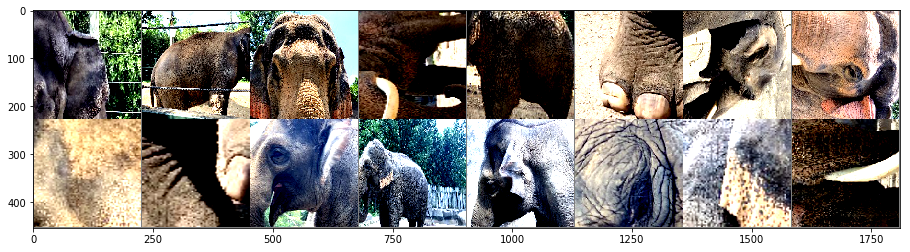

 Sabu  Sabu  Hank  Hank Schottzie  Rudy  Beco  Hank  Rudy  Rudy  Rudy Connie Sunny Pheobe Connie  Hank


In [17]:
## test
classes = ('Beco', 'Connie', 'Hank', 'Jati',
           'MyThai', 'Pheobe', 'Rudy', 'Sabu', 'Schottzie', 'Sunny')
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(20,4))
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))


In [19]:
def adjust_learning_rate(optimizer, epoch):
    
    lr = 1e-6 * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        

In [51]:
## set require grad to false, finetune last later
from torch.utils.model_zoo import tqdm
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

        
def process(train_loader, test_loader):
    ## load resnet model
    model = models.resnet50(pretrained = True)
    num_classes = 10 ## 10 classes
    set_parameter_requires_grad(model)
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes )
    input_size = 224
    
    ## torch is available
    if (torch.cuda.is_available()):
        is_cuda = True
        if torch.cuda.device_count() > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        model = model.cuda()
    else:
        is_cuda = False

    # define loss function (criterion) and optimizer
    criterion = torch.nn.CrossEntropyLoss().cuda()
    
    ## optimizer only on the fc layer
    if torch.cuda.device_count()>1:
        optimizer = torch.optim.SGD(model.module.fc.parameters(), lr = 1e-6,momentum=0.1,
                                weight_decay=1e-4)
    else:
        optimizer = torch.optim.SGD(model.fc.parameters(), lr = lr)
    
    
    # train & test process
    def train(train_loader):
        model.train()
        for (data, target) in tqdm(train_loader):            
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            #print('\rTraining %d/%d' % (batch_idx + 1, len(train_loader)), end='', flush=True)

    
    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                
                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100. * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx
    
    test_accs, confusion_mtxes = [], []    
    for epoch in range(1, 2000):
        adjust_learning_rate(optimizer, epoch)
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print('\r ' , epoch , '/2000, Best test acc = %2.2f%%' %  max(test_accs), end='', flush=True)

    vis(test_accs, confusion_mtxes, classe_labels)
    
    

Dataset: 10760 training samples & 1160 testing samples

Distribution of classes in trainset dataset:


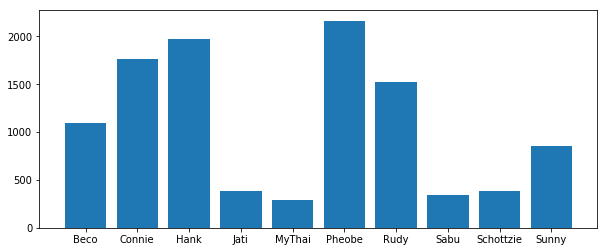

Distribution of classes in test dataset:


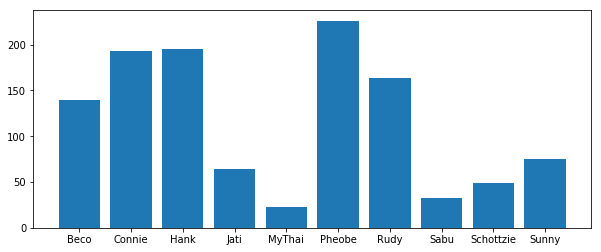

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as sm

import pandas as pd

#!pip install seaborn
import seaborn as sns

print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in trainset dataset:')
fig, ax = plt.subplots(figsize=(10,4))
labels = [label for _, label in train_loader.dataset.imgs]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar([classes[i] for i in (list(classe_labels))], counts)

ax.set_xticks(classe_labels)
plt.show()

print('Distribution of classes in test dataset:')

fig, ax = plt.subplots(figsize=(10,4))
labels = [label for _, label in test_loader.dataset.imgs]
classe_labels, counts = np.unique(labels, return_counts=True)
ax.bar([classes[i] for i in (list(classe_labels))], counts)

ax.set_xticks(classe_labels)
plt.show()

def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, 'g')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt='', cmap="Blues")
    plt.show()

In [ ]:
process(train_loader, test_loader)

Let's use 8 GPUs!


100%|██████████| 43/43 [00:58<00:00,  1.13s/it]


  1 /2000, Best test acc = 13.71%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  2 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:58<00:00,  1.13s/it]


  3 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  4 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  5 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  6 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:58<00:00,  1.12s/it]


  7 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  8 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  9 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  10 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:58<00:00,  1.17s/it]


  11 /2000, Best test acc = 13.79%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  12 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  13 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  14 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  15 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  16 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  17 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  18 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  19 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  20 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  21 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  22 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:58<00:00,  1.14s/it]


  23 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  24 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  25 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  26 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  27 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  28 /2000, Best test acc = 13.97%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  29 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  30 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:58<00:00,  1.15s/it]


  31 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:58<00:00,  1.13s/it]


  32 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  33 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  34 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [01:00<00:00,  1.14s/it]


  35 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  36 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [01:07<00:00,  1.28s/it]


  37 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  38 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.20s/it]


  39 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [01:00<00:00,  1.21s/it]


  40 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  41 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  42 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  43 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  44 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  45 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  46 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [01:00<00:00,  1.19s/it]


  47 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  48 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  49 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  50 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  51 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  52 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  53 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  54 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  55 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  56 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  57 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  58 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  59 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  60 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  61 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  62 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  63 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  64 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  65 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  66 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [01:00<00:00,  1.19s/it]


  67 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  68 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  69 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  70 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  71 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  72 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  73 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  74 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  75 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  76 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  77 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  78 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:58<00:00,  1.13s/it]


  79 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  80 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  81 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  82 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  83 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  84 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  85 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  86 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  87 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  88 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  89 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  90 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  91 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  92 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  93 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  94 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  95 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  96 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  97 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  98 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  99 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  100 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  101 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  102 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  103 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:58<00:00,  1.13s/it]


  104 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  105 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  106 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  107 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  108 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  109 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  110 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  111 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  112 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  113 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  114 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  115 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  116 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  117 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  118 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  119 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  120 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  121 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  122 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  123 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  124 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  125 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  126 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  127 /2000, Best test acc = 14.40%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  128 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  129 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  130 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  131 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  132 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.14s/it]


  133 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  134 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  135 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.15s/it]


  136 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  137 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  138 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  139 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  140 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  141 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  142 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  143 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  144 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  145 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  146 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  147 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  148 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  149 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  150 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  151 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  152 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  153 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  154 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  155 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  156 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  157 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.17s/it]


  158 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.17s/it]


  159 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.17s/it]


  160 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  161 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  162 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.20s/it]


  163 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.17s/it]


  164 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  165 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  166 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  167 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  168 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.17s/it]


  169 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.16s/it]


  170 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  171 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  172 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  173 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.16s/it]


  174 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.21s/it]


  175 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  176 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.14s/it]


  177 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  178 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  179 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  180 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  181 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  182 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  183 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  184 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  185 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  186 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  187 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.16s/it]


  188 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  189 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  190 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  191 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  192 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  193 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  194 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  195 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  196 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  197 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  198 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  199 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  200 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.15s/it]


  201 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  202 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  203 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  204 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  205 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  206 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  207 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  208 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  209 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  210 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  211 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:14<00:00,  1.17s/it]


  212 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  213 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  214 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.16s/it]


  215 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  216 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.17s/it]


  217 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  218 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  219 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  220 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.21s/it]


  221 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.16s/it]


  222 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  223 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.20s/it]


  224 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  225 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  226 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  227 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  228 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  229 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.16s/it]


  230 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  231 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  232 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  233 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  234 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  235 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  236 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  237 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  238 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  239 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  240 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  241 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  242 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  243 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  244 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  245 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  246 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  247 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  248 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  249 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  250 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  251 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  252 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  253 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  254 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.20s/it]


  255 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  256 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  257 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  258 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  259 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  260 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  261 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  262 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  263 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  264 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  265 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  266 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  267 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  268 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  269 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  270 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  271 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  272 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  273 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  274 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  275 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  276 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  277 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  278 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  279 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  280 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  281 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  282 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  283 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  284 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  285 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.18s/it]


  286 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  287 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  288 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  289 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  290 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  291 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  292 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  293 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  294 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  295 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  296 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  297 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  298 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  299 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  300 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  301 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.15s/it]


  302 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  303 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  304 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  305 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  306 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  307 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  308 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  309 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  310 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  311 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  312 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  313 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  314 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  315 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:01<00:00,  1.19s/it]


  316 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  317 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  318 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  319 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  320 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  321 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  322 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  323 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  324 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.20s/it]


  325 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  326 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.15s/it]


  327 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  328 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  329 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  330 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  331 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.20s/it]


  332 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  333 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  334 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  335 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  336 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  337 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  338 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  339 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  340 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  341 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  342 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.20s/it]


  343 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  344 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  345 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  346 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  347 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  348 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  349 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  350 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  351 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.18s/it]


  352 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  353 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  354 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  355 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  356 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  357 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  358 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  359 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  360 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  361 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  362 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  363 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  364 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  365 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  366 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  367 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  368 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  369 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  370 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.18s/it]


  371 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  372 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  373 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  374 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  375 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  376 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  377 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  378 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  379 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  380 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  381 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  382 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  383 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  384 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  385 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  386 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  387 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  388 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  389 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  390 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  391 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  392 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [01:00<00:00,  1.18s/it]


  393 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  394 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  395 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  396 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.20s/it]


  397 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  398 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  399 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  400 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  401 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:58<00:00,  1.16s/it]


  402 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.19s/it]


  403 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  404 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  405 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.20s/it]


  406 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  407 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  408 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  409 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  410 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  411 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  412 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.17s/it]


  413 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.14s/it]


  414 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  415 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  416 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  417 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  418 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  419 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.18s/it]


  420 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.13s/it]


  421 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.16s/it]


  422 /2000, Best test acc = 14.57%

100%|██████████| 43/43 [00:59<00:00,  1.15s/it]


  423 /2000, Best test acc = 14.57%

 74%|███████▍  | 32/43 [00:44<00:15,  1.37s/it]